In [1]:
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler

from collections import OrderedDict

In [2]:
timestamp_start = 50

In [3]:
# Temperature for the two consecutive timestamp
temperature_t0 = []
temperature_t1 = []

# Folder Path
path = "solutions"
  
# Read text File  
def read_text_file(file_path):
    with h5py.File(file_path, 'r') as f:
        temperature_t0.append(f['temperature'][:][timestamp_start])
        temperature_t1.append(f['temperature'][:][timestamp_start+1])
        
# Iterate through all file
for file in os.listdir(path):
    file_path = f"{path}/{file}"
  
    # call read text file function
    read_text_file(file_path)
    #print(f"{file_path} is finished reading")

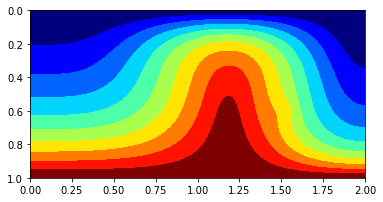

In [4]:
plt.close(1)
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.imshow(temperature_t0[1],
          cmap=cm.get_cmap('jet', 10),
          extent=(0, 2, 0, 1))

ax.invert_yaxis()
plt.show()

In [5]:
#Parameters
n_epoch = 200
batch_size = 1
lr = 5e-5
accurate_loss_baseline = 0.0005

In [6]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print("Current device is ",device)

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu


In [7]:
print(max(np.asarray(temperature_t1).flatten()))

1.1885064


In [8]:
# Customised Dataset class
class KMNIST(Dataset):
    
    def __init__(self,dataset):
        # Load the data from two consecutive timestamps of temperature 
        self.data = dataset
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_item = self.data[index]
        
        return data_item

In [9]:
temperature_dataset = KMNIST(
    np.asarray(temperature_t0+temperature_t1)
)


generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset, validation_dataset = random_split(temperature_dataset, [0.8,0.1,0.1], generator = generator)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size = batch_size,
    shuffle = False
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [10]:
train_data = next(iter(train_loader))

print(f"data batch shape: {train_data.size()}")

test_index = 0
train_data_batch_sample = train_data[test_index]

print(f"Input: {train_data_batch_sample}")

data batch shape: torch.Size([1, 201, 401])
Input: tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0079, 1.0077, 1.0083,  ..., 0.9955, 0.9955, 0.9955],
        [1.0156, 1.0153, 1.0165,  ..., 0.9911, 0.9911, 0.9911],
        ...,
        [0.0287, 0.0287, 0.0287,  ..., 0.0108, 0.0108, 0.0108],
        [0.0144, 0.0144, 0.0144,  ..., 0.0054, 0.0054, 0.0054],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [11]:
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :201, :]
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential( # 201x401 => 
            nn.Conv2d(1, 3, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            #nn.BatchNorm2d(3),
            nn.Conv2d(3, 6, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            #nn.BatchNorm2d(6),
            nn.Conv2d(6, 9, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            #nn.BatchNorm2d(9), 
        )
        
    def forward(self, x):
        out=self.encoder(x)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential( # 201x401 => 
            nn.ConvTranspose2d(9, 6, stride=(3, 3), kernel_size=(5, 5), padding=(2,1)),
            nn.Tanh(),
            #nn.BatchNorm2d(6),
            nn.ConvTranspose2d(6, 3, stride=(3, 3), kernel_size=(5, 5), padding=(0,2)),
            nn.Tanh(),
            #nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 1, stride=(3, 3), kernel_size=(5, 5), padding=(2,0)),
            #nn.Tanh(),
            #nn.BatchNorm2d(1),
            Trim(),
        )
        

    def forward(self, x):
        out=self.decoder(x)
        return out

In [12]:
# pip3 install torchsummary
from torchsummary import summary
encoder = Encoder().to(device)
decoder = Decoder().to(device)
print(summary(encoder, (1, 201, 401)))
print(summary(decoder, (9, 8, 15)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 3, 67, 134]              78
              Tanh-2           [-1, 3, 67, 134]               0
            Conv2d-3            [-1, 6, 23, 45]             456
              Tanh-4            [-1, 6, 23, 45]               0
            Conv2d-5             [-1, 9, 8, 15]           1,359
              Tanh-6             [-1, 9, 8, 15]               0
Total params: 1,893
Trainable params: 1,893
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.31
Forward/backward pass size (MB): 0.52
Params size (MB): 0.01
Estimated Total Size (MB): 0.84
----------------------------------------------------------------
None
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 6, 

In [13]:
# Training Function
def train(encoder, decoder, train_loader, val_loader, device, optimizer, n_epoch):
    
    criterion = nn.MSELoss()
    
    minimum_validation_loss = 10000000
    best_model_index = -1
    
    running_loss_list = []
    validation_loss_list = []

    # n_epoch times of iterations
    for epoch in range(n_epoch):

        running_loss = 0.0
        
        for data in train_loader:
            # get a batch of inputs and labels
            inputs= data.to(device)
            inputs = inputs.view(inputs.shape[0], 1, 201,401)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Get output features, calculate loss and optimize
            outputs = encoder(inputs)
            outputs = decoder(outputs)
            loss = criterion(outputs, inputs)
            
            loss.backward()
            optimizer.step()

            # Add to the total training loss
            running_loss += loss.item()

        # print some statistics
        if epoch+1 == n_epoch // 4:
            print("25% of the training has finished")
                
        if epoch+1 == n_epoch // 2:
            print("50% of the training has finished")
                
        if epoch+1 == 3 * n_epoch // 4:
            print("75% of the training has finished")
            
        print(epoch+1,"epochs have finished")
        print("Current training loss is ",running_loss)
        running_loss_list.append(running_loss)
        running_loss = 0.0

        # Valiadation
        with torch.no_grad():
            correct = 0
            total = 0
            valid_loss = 0.0
            for data in val_loader:
                inputs = data.to(device)
                inputs = inputs.view(inputs.shape[0], 1, 201,401)
                
                # Get output features and calculate loss
                outputs = encoder(inputs)
                outputs = decoder(outputs)
                loss = criterion(outputs, inputs)
                
                # If the loss value is less than accurate loss baseline, we consider it being accurate
                for j in range(len(data)):
                    single_loss = criterion(outputs[j], inputs[j])
                    if single_loss.item() <= accurate_loss_baseline:
                        correct += 1
                    total += 1
    
                # Add to the validation loss
                valid_loss += loss.item()

            # Calculate valiadation accuracy and print Validation statistics
            print("Validation loss for this epoch is",valid_loss)
            print("Validation Accuracy for this epoch is", 100*correct//total)
            validation_loss_list.append(valid_loss)

        # Update the statistics for the best model
        if valid_loss <= minimum_validation_loss:
            minimum_validation_loss = valid_loss
            
            best_model_index = epoch
            
        print()
    
    # Training finished, print the statistics for the best model
    print('Training Finished')
    print("Best model has a validation loss of {} and it's in epoch {}".format(minimum_validation_loss, best_model_index+1))
    
    # Plot the Training loss and validation loss during training
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(running_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss in each epoch')

    plt.subplot(2, 1, 2)
    plt.plot(validation_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss in each epoch')
    
    plt.subplots_adjust(hspace=1)
    
    plt.show()

In [14]:
optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=lr)

1 epochs have finished
Current training loss is  47.54433715343475
Validation loss for this epoch is 5.6887906193733215
Validation Accuracy for this epoch is 0

2 epochs have finished
Current training loss is  42.033287301659584
Validation loss for this epoch is 4.748166784644127
Validation Accuracy for this epoch is 0

3 epochs have finished
Current training loss is  33.76007127761841
Validation loss for this epoch is 3.7120200395584106
Validation Accuracy for this epoch is 0

4 epochs have finished
Current training loss is  26.155409157276154
Validation loss for this epoch is 2.8372978270053864
Validation Accuracy for this epoch is 0

5 epochs have finished
Current training loss is  19.45839899778366
Validation loss for this epoch is 2.0991046875715256
Validation Accuracy for this epoch is 0

6 epochs have finished
Current training loss is  14.906366989016533
Validation loss for this epoch is 1.655831404030323
Validation Accuracy for this epoch is 0

7 epochs have finished
Current tr

51 epochs have finished
Current training loss is  0.18741042050532997
Validation loss for this epoch is 0.022904915211256593
Validation Accuracy for this epoch is 0

52 epochs have finished
Current training loss is  0.1822234308347106
Validation loss for this epoch is 0.02227266866248101
Validation Accuracy for this epoch is 0

53 epochs have finished
Current training loss is  0.17730123706860468
Validation loss for this epoch is 0.021845410868991166
Validation Accuracy for this epoch is 0

54 epochs have finished
Current training loss is  0.1729060290963389
Validation loss for this epoch is 0.02107482706196606
Validation Accuracy for this epoch is 0

55 epochs have finished
Current training loss is  0.1683496024343185
Validation loss for this epoch is 0.020543855265714228
Validation Accuracy for this epoch is 0

56 epochs have finished
Current training loss is  0.1641677666339092
Validation loss for this epoch is 0.020046439894940704
Validation Accuracy for this epoch is 0

57 epochs 

101 epochs have finished
Current training loss is  0.08504147970234044
Validation loss for this epoch is 0.01014354030485265
Validation Accuracy for this epoch is 40

102 epochs have finished
Current training loss is  0.08371942490339279
Validation loss for this epoch is 0.009991855535190552
Validation Accuracy for this epoch is 45

103 epochs have finished
Current training loss is  0.08237159138661809
Validation loss for this epoch is 0.009824646927881986
Validation Accuracy for this epoch is 50

104 epochs have finished
Current training loss is  0.0810552243492566
Validation loss for this epoch is 0.00967588831554167
Validation Accuracy for this epoch is 50

105 epochs have finished
Current training loss is  0.0795656928094104
Validation loss for this epoch is 0.009494774451013654
Validation Accuracy for this epoch is 60

106 epochs have finished
Current training loss is  0.07812785674468614
Validation loss for this epoch is 0.009327562671387568
Validation Accuracy for this epoch is 

75% of the training has finished
150 epochs have finished
Current training loss is  0.02978327209712006
Validation loss for this epoch is 0.003878843068378046
Validation Accuracy for this epoch is 100

151 epochs have finished
Current training loss is  0.029342989495489746
Validation loss for this epoch is 0.0037542023055721074
Validation Accuracy for this epoch is 100

152 epochs have finished
Current training loss is  0.028804233625123743
Validation loss for this epoch is 0.003818800272711087
Validation Accuracy for this epoch is 100

153 epochs have finished
Current training loss is  0.02839818309439579
Validation loss for this epoch is 0.0036486760873231106
Validation Accuracy for this epoch is 100

154 epochs have finished
Current training loss is  0.02797764661954716
Validation loss for this epoch is 0.003594885944039561
Validation Accuracy for this epoch is 100

155 epochs have finished
Current training loss is  0.027690357390383724
Validation loss for this epoch is 0.0035417962

198 epochs have finished
Current training loss is  0.017078694469091715
Validation loss for this epoch is 0.0022059841830923688
Validation Accuracy for this epoch is 100

199 epochs have finished
Current training loss is  0.016825971219077474
Validation loss for this epoch is 0.002163759112590924
Validation Accuracy for this epoch is 100

200 epochs have finished
Current training loss is  0.01668392962528742
Validation loss for this epoch is 0.0021519142319448292
Validation Accuracy for this epoch is 100

Training Finished
Best model has a validation loss of 0.0021519142319448292 and it's in epoch 200


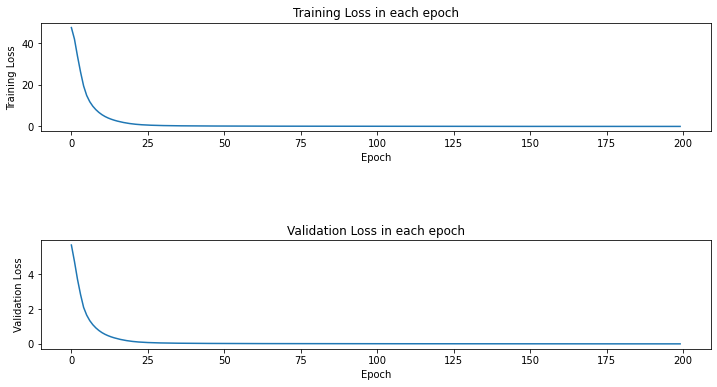

In [15]:
train(encoder, decoder, train_loader, validation_loader, device, optimizer, n_epoch)

In [16]:
def test(encoder, decoder, test_loader, device):

    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs = data.to(device)
            inputs = inputs.view(inputs.shape[0], 1, 201,401)
                
            # Get output features and calculate loss
            outputs = encoder(inputs)
            outputs = decoder(outputs)
            loss = criterion(outputs, inputs)
                
            # If the loss value is less than 0.01, we consider it being accurate
            for j in range(len(inputs)):
                single_loss = criterion(outputs[j], inputs[j])
                if single_loss.item() <= accurate_loss_baseline:
                    correct += 1
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    print(max(best_worst_input_list[0].detach().numpy()[0].flatten()))
    print(max(best_worst_predicted_list[0].detach().numpy()[0].flatten()))
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_input_list[0].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case predicted output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_predicted_list[0].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    print(max(best_worst_input_list[1].detach().numpy()[0].flatten()))
    print(max(best_worst_predicted_list[1].detach().numpy()[0].flatten()))
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_input_list[1].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case predicted output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_predicted_list[1].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))

    ax.invert_yaxis()
    plt.show()

Total loss for the model is 0.016527213316294365
Accuracy for the model is 100

Best model has a error of  4.177710070507601e-05
1.0
1.03507


<ipython-input-16-b48a218287c4>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


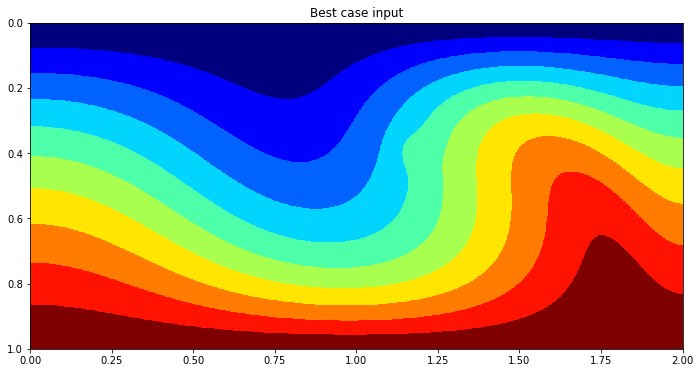

<ipython-input-16-b48a218287c4>:72: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


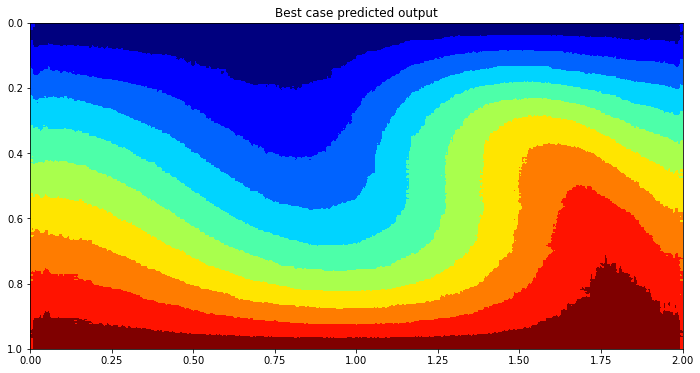

Worst model has a error of  0.00020009097352158278
1.0908114
1.0832722


<ipython-input-16-b48a218287c4>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


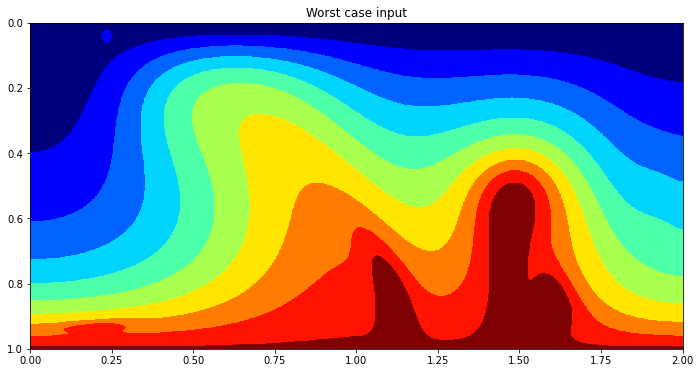

<ipython-input-16-b48a218287c4>:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


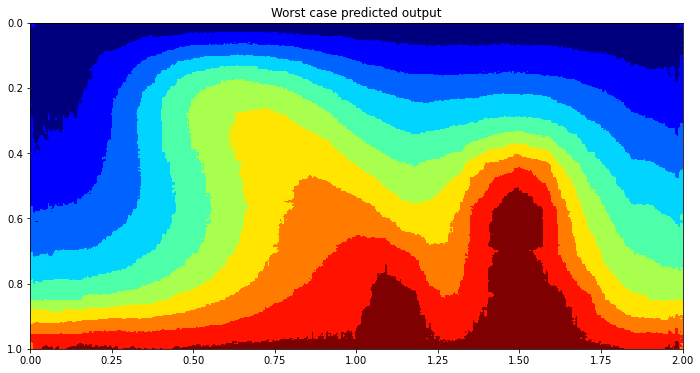

In [17]:
test(encoder, decoder, train_loader, device)

Total loss for the model is 0.002314012512215413
Accuracy for the model is 100

Best model has a error of  5.082637653686106e-05
1.0
1.0226538


<ipython-input-16-b48a218287c4>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


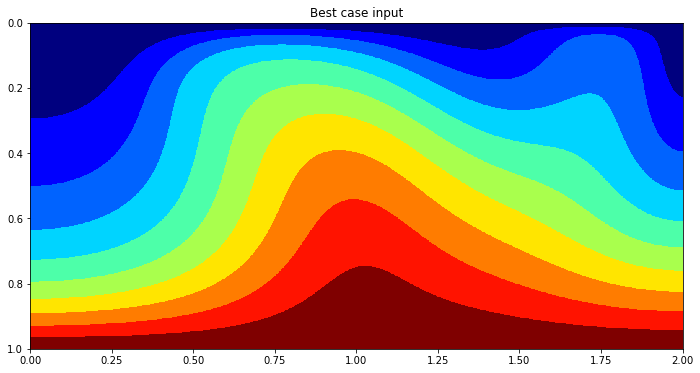

<ipython-input-16-b48a218287c4>:72: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


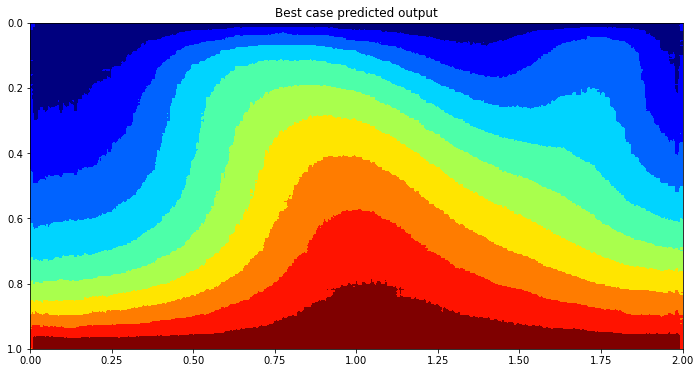

Worst model has a error of  0.00028267770539969206
1.1886628
1.1870313


<ipython-input-16-b48a218287c4>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


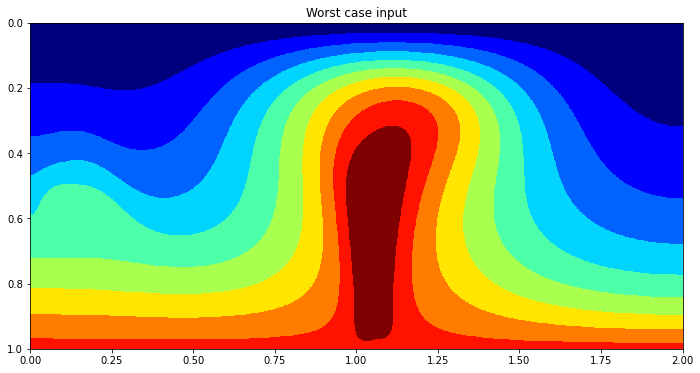

<ipython-input-16-b48a218287c4>:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


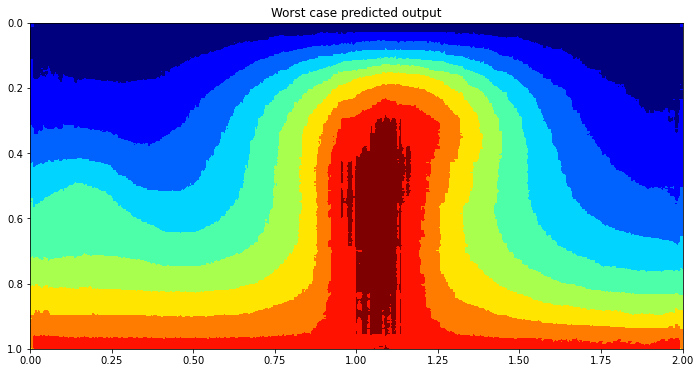

In [18]:
test(encoder, decoder, test_loader, device)